%%latex
\tableofcontents

In [166]:
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor 
import matplotlib.cm as cm
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
# from nnc2p import NeuralNetwork # our own architecture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Own neural network architecture defined here: (note: in the script, it gives errors and the notebook has to be reloaded sometimes)

In [49]:
class NeuralNetwork(nn.Module):
    """
    Implements a two-layered neural network for the C2P conversion. Note that hence the number of layers is fixed
    for this NN subclass! The activation functions are sigmoids.
    """
    def __init__(self, name: str = "network", h1: int = 600, h2: int = 200, reg: bool = False) -> None:
        """
        Initialize the neural network class.
        :param name: String that names this network, in order to recognize it later on.
        :param h1: Size (number of neurons) of the first hidden layer.
        :param h2: Size (number of neurons) of the second hidden layer.
        """
        # Call the super constructor first
        super(NeuralNetwork, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h1 = h1
        self.h2 = h2

        # Add field to specify whether or not we do regularization
        self.regularization = reg
        self.name = name

        # Define the weights:
        self.linear1 = nn.Linear(3, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2, 1)

        # Network uses sigmoid activation functions. Input has size 3 (D, S, tau) and returns the pressure.
        # previous code:
        # self.stack = nn.Sequential(
        #     nn.Linear(3, h1),
        #     nn.Sigmoid(),
        #     nn.Linear(h1, h2),
        #     nn.Sigmoid(),
        #     nn.Linear(h2, 1)
        # )

    # TODO - what is input type here?
    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """

        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        return x

    def load_parameters(self, state_dict):
        """
        Loads the parameters, as saved before, into this network's layers. Note: assumes 2-layer network, same size.
        Explanation: we changed the details of the neural network architecture definition to have named modules in order
        to better control the pruning methods.

        :param state_dict: A state_dict containing parameters.
        :return: None
        """

        # First layer
        stack_0_weight = state_dict['stack.0.weight']
        stack_0_bias   = state_dict['stack.0.bias']
        self.linear1.weight = nn.parameter.Parameter(stack_0_weight)
        self.linear1.bias  = nn.parameter.Parameter(stack_0_bias)

        # Second layer
        stack_2_weight = state_dict['stack.2.weight']
        stack_2_bias = state_dict['stack.2.bias']
        self.linear2.weight = nn.parameter.Parameter(stack_2_weight)
        self.linear2.bias = nn.parameter.Parameter(stack_2_bias)

        # Third layer
        stack_4_weight = state_dict['stack.4.weight']
        stack_4_bias = state_dict['stack.4.bias']
        self.linear3.weight = nn.parameter.Parameter(stack_4_weight)
        self.linear3.bias = nn.parameter.Parameter(stack_4_bias)


# Introduction

We have trained model which is succesful in the C2P conversion based on the paper by Dieselhorst et al., and this neural network is called NNC2Pv0. We trained it a bit longer compared to the paper, and ended up with an efficient network called `NNC2Pv0t2`. Naturally, we want to improve on these methods. One possibility is __pruning the neural network__ to speed up the computations.

__Get the data into dataloaders:__

In [50]:
# Specify the desired CSV file locations of train and test data
training_data_csv = data.read_training_data("D:/Coding/master-thesis-AI/data/NNC2P_data_train.csv")
test_data_csv        = data.read_training_data("D:/Coding/master-thesis-AI/data/NNC2P_data_test.csv")
# Load them as CustomDatasets
training_data = data.CustomDataset(training_data_csv)
test_data        = data.CustomDataset(test_data_csv)

In [51]:
# Put this data into a DataLoader
train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

Load a previously trained model:

In [114]:
device = "cpu"
# Initialize a random neural network
model = NeuralNetwork().to(device)

In [115]:
# Load the previously trained model and its parameters
old_model = torch.load("D:/Coding/master-thesis-AI/Models/NNC2Pv0t2.pth")
model_state_dict = torch.load("D:/Coding/master-thesis-AI/Models/NNC2Pv0t2_state_dict.pth")

In [116]:
print(model_state_dict.keys())

odict_keys(['stack.0.weight', 'stack.0.bias', 'stack.2.weight', 'stack.2.bias', 'stack.4.weight', 'stack.4.bias'])


In [117]:
print(model_state_dict['stack.4.bias'])

tensor([0.1305])


Load the old model's parameters into the new architecture

In [118]:
model.load_parameters(model_state_dict)

In [119]:
print(model)

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=1, bias=True)
)


In [120]:
test = torch.tensor([10.204131145455385, 12.026584842282125, 22.131296926293793])
print(model(test).item())

12.866371154785156


What is the performance of this network?

In [103]:
nnc2p.measure_performance(model, test_data, verbose=False)

(0.00026232592464366463, 0.008344985544681549)

How does the state_dict look like in the current neural network architecture? `<layer_name>.weight` et cetera

In [104]:
for param in model.state_dict():
    print(param)
    print(model.state_dict()[param].size())

linear1.weight
torch.Size([600, 3])
linear1.bias
torch.Size([600])
linear2.weight
torch.Size([200, 600])
linear2.bias
torch.Size([200])
linear3.weight
torch.Size([1, 200])
linear3.bias
torch.Size([1])


# Own pruning methods

## Deleting rows and columns

In [105]:
# def delete_column(x, index):
#     """
#     Prunes a matrix by deleting a column of the matrix.
#     :param x: Torch tensor with shape (n, m)
#     :param index: Index of column to be deleted.
#     :return: Torch tensor with shape (n, m-1).
#     """
    
#     # Delete the column by splitting into two pieces, transpose the tensors for cat
#     a = torch.transpose(x[:, :index], 0, 1)
#     b = torch.transpose(x[:, index+1:], 0, 1)
    
#     # Concatenate the two results, with the desired column deleted
#     new = torch.cat((a, b))
    
#     return torch.transpose(new, 0, 1)

In [106]:
# def delete_row(x, index):
#     """
#     Prunes a matrix by deleting a column of the matrix.
#     :param x: Torch tensor with shape (n, m)
#     :param index: Index of column to be deleted.
#     :return: Torch tensor with shape (n-1, m).
#     """
    
#     # Delete the column by splitting into two pieces, transpose the tensors for cat
#     a = x[:index]
#     b = x[index+1:]
    
#     # Return concatenation    
#     return torch.cat((a, b))

In [107]:
# def prune_bias(b, index):
#     """
#     Prunes the bias vector, by deleting the entry of the bias vector at specified index.
#     """
    
#     # Get everything occuring before and after the index position
#     before = b[:index]
#     after = b[index+1:]
    
#     # Return the concatenation
#     return torch.cat([before, after])

## Pruning methods

Show test cases:

In [108]:
# example_matrix = torch.tensor([i for i in range(9)]).reshape((3, 3))
# print(example_matrix)
# print(np.shape(example_matrix))
# print("---")
# new = delete_column(example_matrix, 1)
# print(new)
# print(np.shape(new))
# print("---")
# new = delete_row(example_matrix, 1)
# print(new)
# print(np.shape(new))

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
torch.Size([3, 3])
---
tensor([[0, 2],
        [3, 5],
        [6, 8]])
torch.Size([3, 2])
---
tensor([[0, 1, 2],
        [6, 7, 8]])
torch.Size([2, 3])


In [109]:
# x = torch.tensor([i for i in range(10)])
# prune_bias(x, 4)

tensor([0, 1, 2, 3, 5, 6, 7, 8, 9])

## Pruning methods

### Single pruning

In [91]:
# def prune(old_model, layer_index, neuron_index):
#     """
#     Prunes a neural network given the hidden layer index and the neuron index. Note: we assume two layers
#     """
    
#     # Get the weights and biases of the old model
#     state_dict             = old_model.state_dict()
#     state_dict_items = state_dict.items()
#     # Copy the state dict of original model
#     new_state_dict = state_dict.copy()
    
#     # For convenience, get the sizes of the hidden layers from the old network
#     h1 = old_model.h1
#     h2 = old_model.h2
    
#     # Based on the layer_index, get the correct layers' parameters' names:
#     this_layer_name  = "linear" + str(layer_index)
#     next_layer_name = "linear" + str(layer_index+1)
    
#     this_weight_name  = this_layer_name + ".weight"
#     this_bias_name       = this_layer_name + ".bias"
#     next_weight_name = next_layer_name + ".weight"
    
#     # Now, get these parameters:
#     this_weight  = state_dict[this_weight_name]
#     this_bias       = state_dict[this_bias_name]
#     next_weight = state_dict[next_weight_name]
    
#     # Prune the matrices:
#     this_weight  = delete_row(this_weight, neuron_index)
#     this_bias       = prune_bias(this_bias, neuron_index)
#     next_weight = delete_column(next_weight, neuron_index)
    
#     # Update these parameters in the new state dict
#     new_state_dict[this_weight_name]  = this_weight
#     new_state_dict[this_bias_name]       = this_bias
#     new_state_dict[next_weight_name] = next_weight
    
#     # Get the new model. First, instantiate a random architecture, with correct sizes
#     if layer_index == 1:
#         h1 = h1 - 1
#     else:
#         h2 = h2 - 1
    
#     new_model = NeuralNetwork(h1 = h1, h2 = h2)
    
#     # Now, load the pruned model's weights into the architecture
#     new_model.load_state_dict(new_state_dict)
    
#     return new_model

In [87]:
# # test
# new_model = prune_nn(model, 1, 100)
# print(new_model)
# # Compare the performances
# nnc2p.measure_performance(model, test_data)
# nnc2p.measure_performance(new_model, test_data)

### Find optimal neuron to prune

In [183]:
model

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=1, bias=True)
)

In [184]:
start = time.time()
best_layer_index, best_neuron_index, best_performance, values_dict = nnc2p.find_optimal_neuron_to_prune(model)
end = time.time()
print(f"Running time was {round(end - start)} seconds")


Layer index: 1

Neuron index: 599 out of 600
Layer index: 2

Running time was 136 seconds


In [186]:
print(f"Best layer index: {best_layer_index}, best neuron index: {best_neuron_index}")

Best layer index: 2, best neuron index: 96


Now, prune it:

In [187]:
pruned = nnc2p.prune(model, best_layer_index, best_neuron_index)

In [188]:
print(pruned)

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=199, bias=True)
  (linear3): Linear(in_features=199, out_features=1, bias=True)
)


__TESTING__ Loop of several pruning and possibly retraining

In [189]:
# prune N times the model
N = 5
test = nnc2p.hill_climbing_pruning(model, N)


Layer index: 1

Neuron index: 599 out of 600
Layer index: 2

Pruned 1/5. Performance is 1.8426219197414948e-07

Layer index: 1

Neuron index: 599 out of 600
Layer index: 2

Pruned 2/5. Performance is 2.649638938917956e-07

Layer index: 1

Neuron index: 599 out of 600
Layer index: 2

Pruned 3/5. Performance is 2.589616317371747e-07

Layer index: 1

Neuron index: 599 out of 600
Layer index: 2

Pruned 4/5. Performance is 1.928351684376657e-07

Layer index: 1

Neuron index: 599 out of 600
Layer index: 2

Pruned 5/5. Performance is 1.504391870896992e-07


What does the latest model look like?

In [190]:
print(test)

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=195, bias=True)
  (linear3): Linear(in_features=195, out_features=1, bias=True)
)


Now, check the performance on the test set again.

In [193]:
nnc2p.measure_performance(model, test_data, verbose=True)
nnc2p.measure_performance(test, test_data, verbose=True)

Errors: 2.623259e-04  with L1, 2.623259e-04  with L2 and 8.344986e-03 with Linfty
Errors: 2.633248e-04  with L1, 2.633248e-04  with L2 and 8.378468e-03 with Linfty


(0.0002633247790945461, 2.0028044234177137e-07, 0.008378468453884125)

### Compare norms after pruning

Get the baseline errors to compare to:

In [173]:
# base_line_l1, base_line_l2, base_line_linfty = nnc2p.measure_performance(model, validation_set, verbose=False)
# base_line_dict = {'l1_norm': base_line_l1, 'l2_norm': base_line_l2, 'linfty_norm': base_line_linfty}

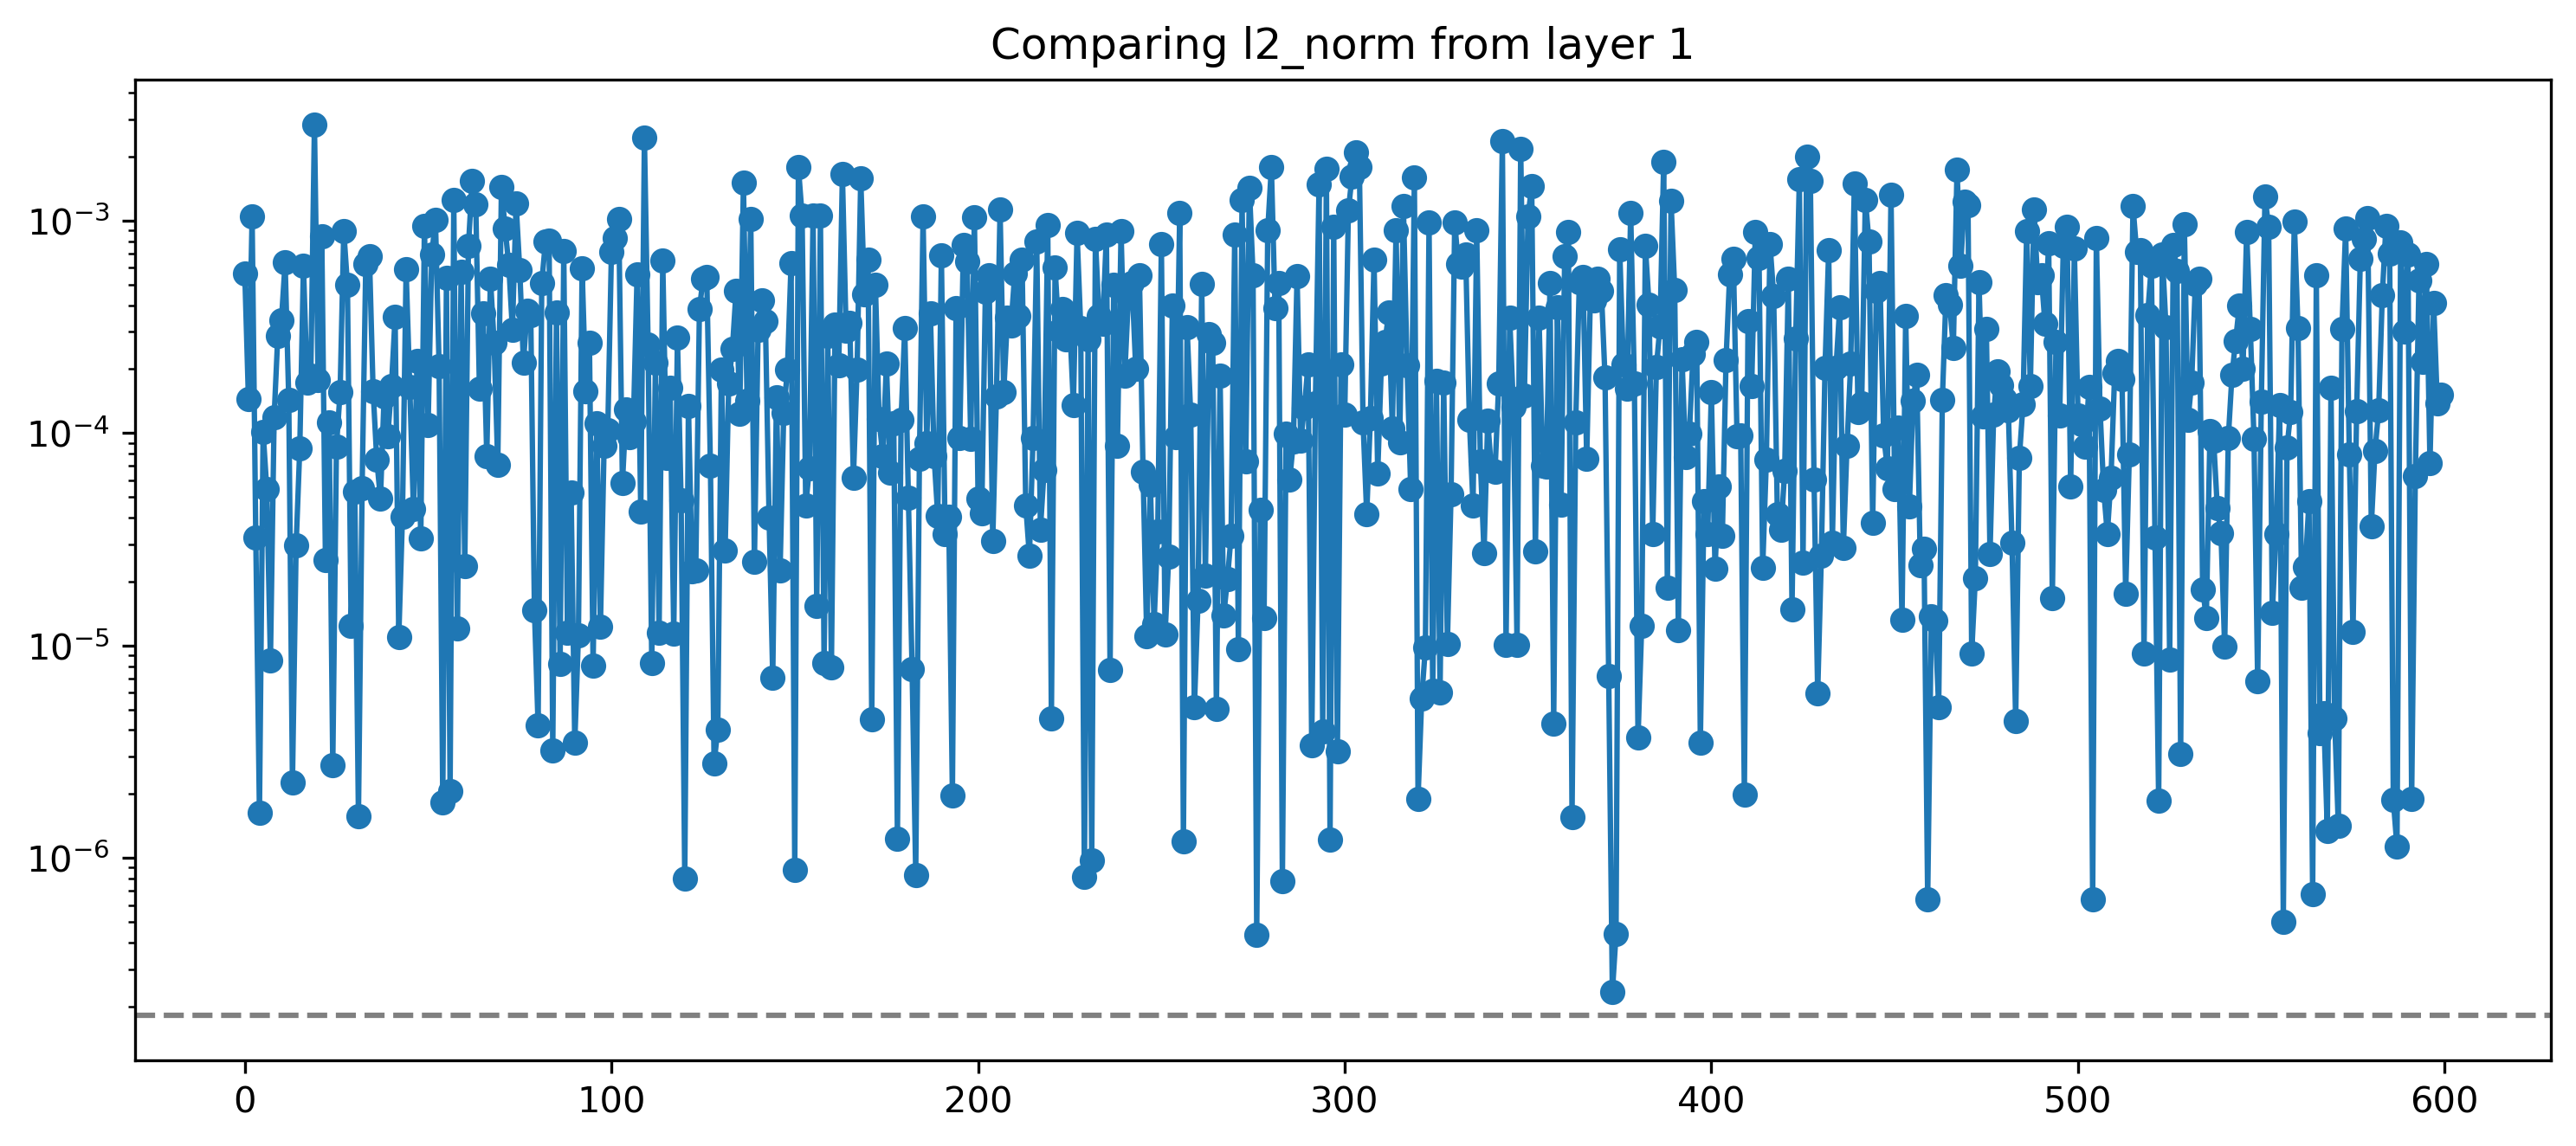

In [180]:
# # Get values depending on chosen norm
# which_layer = 1; which_norm = 'l2_norm'
# values = []
# for i, value in enumerate(values_dict[which_norm]):
#     if(values_dict['layer_index'][i] == which_layer):
#         values.append(value)
        
# # Get figure
# plt.figure(figsize=(12,5))
# plt.plot(values, '-o')
# plt.axhline(base_line_dict[which_norm], ls='--', color='gray')
# plt.yscale('log')
# plt.title("Comparing " + which_norm + " from hidden layer " + str(which_layer))
# plt.show()

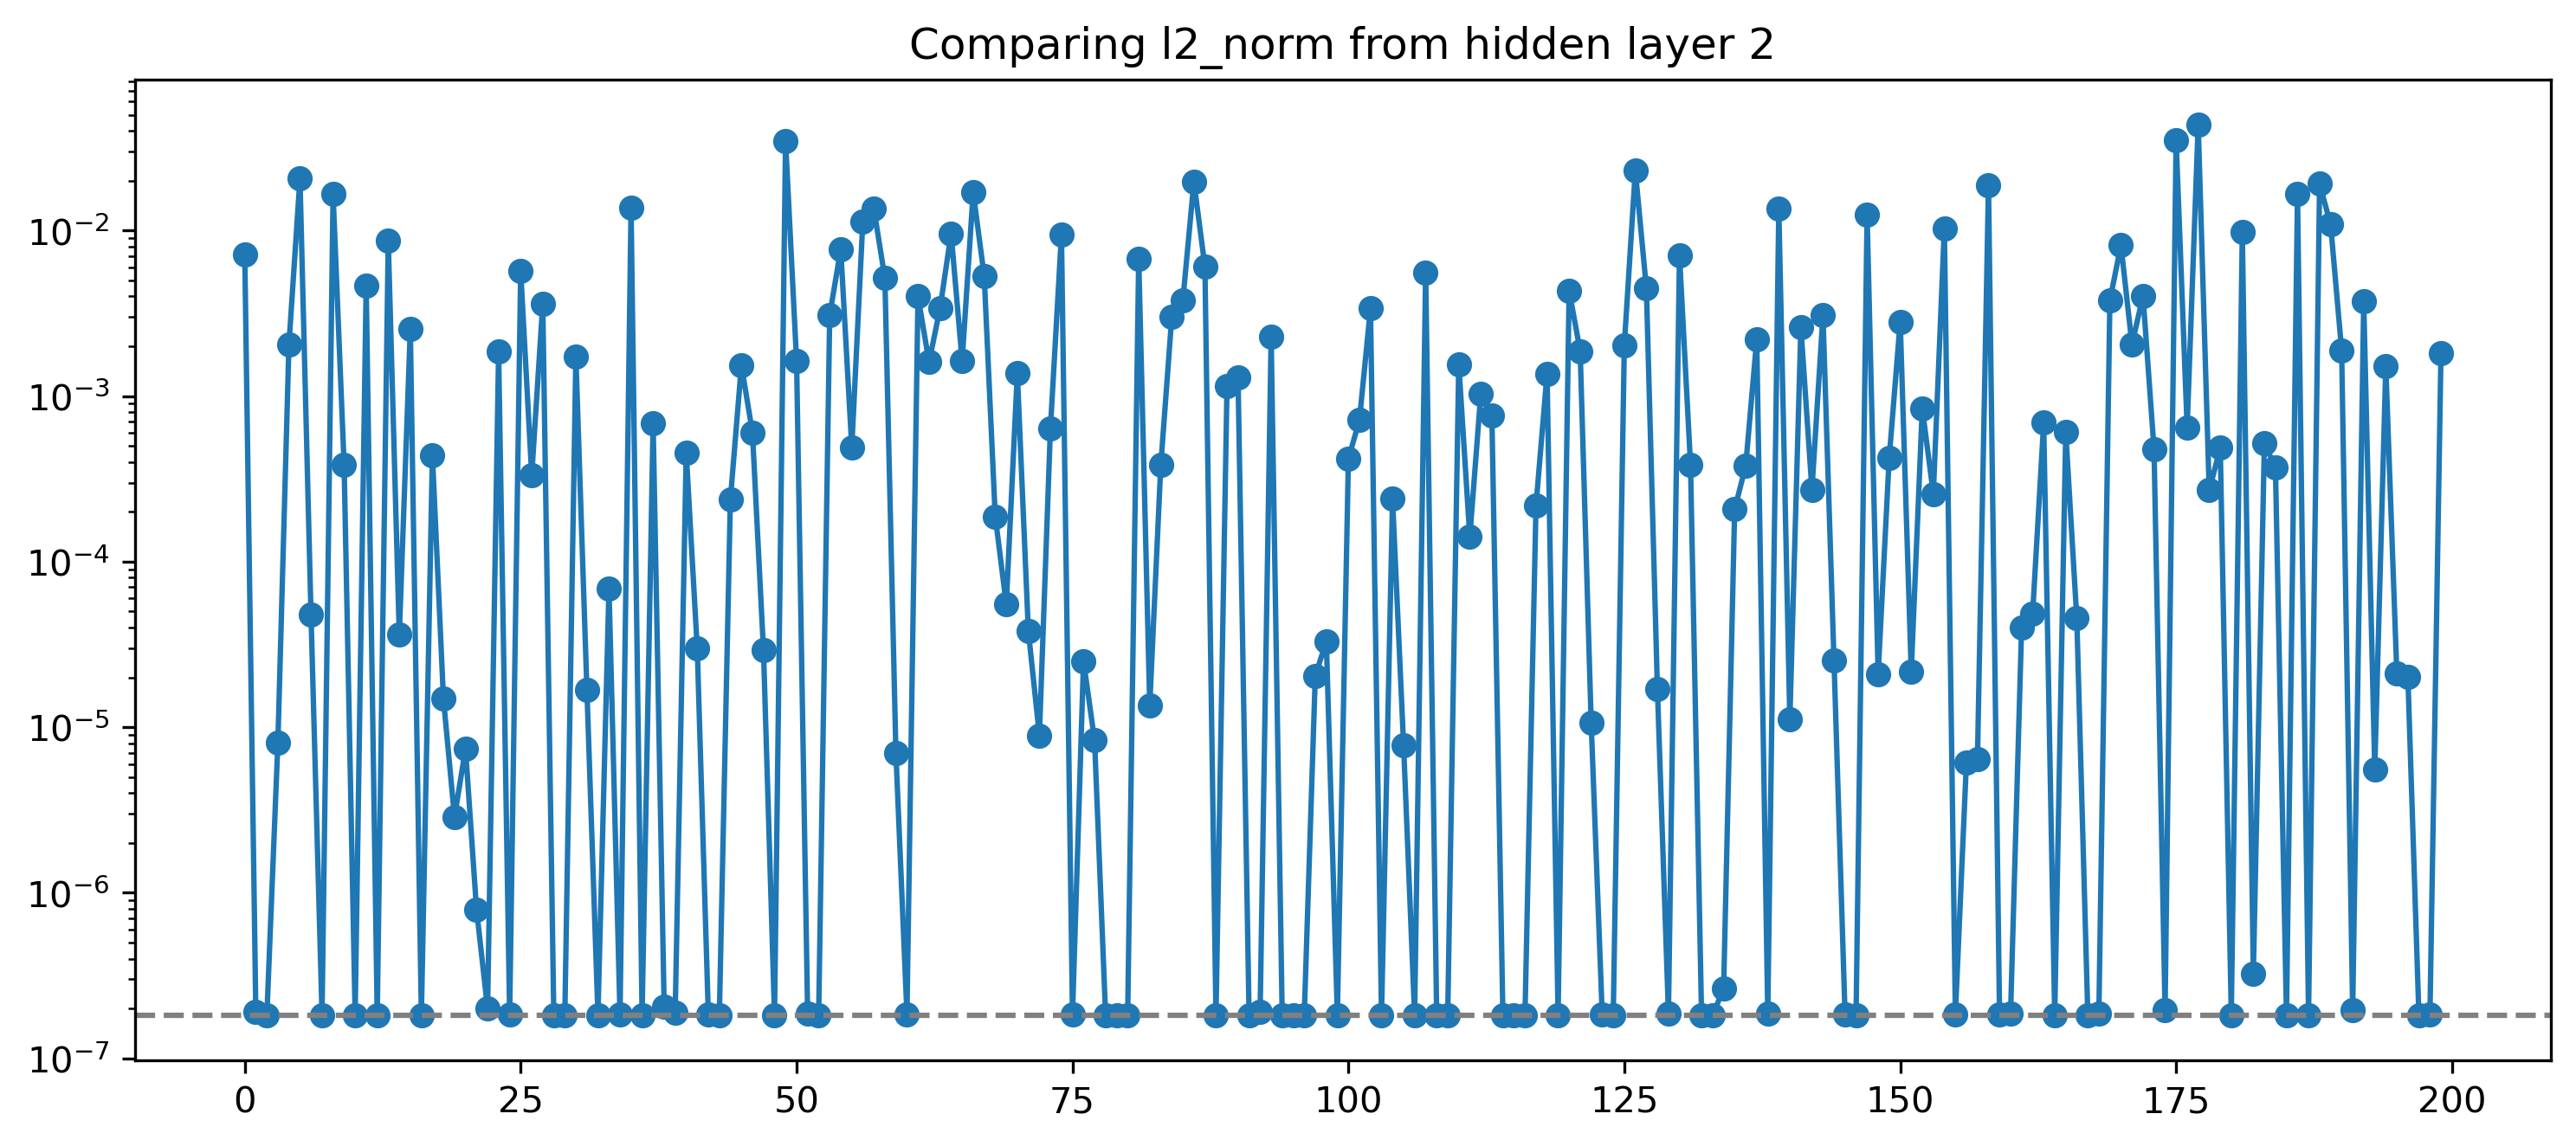

In [181]:
# Get values depending on chosen norm
which_layer = 2; which_norm = 'l2_norm'
values = []
for i, value in enumerate(values_dict[which_norm]):
    if(values_dict['layer_index'][i] == which_layer):
        values.append(value)
        
# Get figure
plt.figure(figsize=(12,5))
plt.plot(values, '-o')
plt.axhline(base_line_dict[which_norm], ls='--', color='gray')
plt.yscale('log')
plt.title("Comparing " + which_norm + " from hidden layer " + str(which_layer))
plt.show()

## Performance after pruning

In [35]:
number = 20
new_model = prune_nn(NNC2P, number=number)
model = new_model
models = [NNC2P, new_model]
names = ["NNC2P", "pruned"]

for i in range(len(models)):
    # Get model and name
    model = models[i]
    name = names[i]

    # Get predictions
    with torch.no_grad():
        p_hat= np.array([])
        for input_values in test_features:
            prediction = model(input_values)
            p_hat = np.append(p_hat, prediction[0].item())

    # Get labels as np arrays
    p = np.array([])
    for value in test_labels:
        p = np.append(p, value.item())

    # Get the errors:
    delta_p_L1       = L1_norm(p_hat, p)
    delta_p_Linfty = Linfty_norm(p_hat, p)

    print("Errors for p: %e  with L1 and %e with Linfty for %s with %d neurons pruned" % (delta_p_L1, delta_p_Linfty, name, number) )

Errors for p: 2.623259e-04  with L1 and 8.344986e-03 with Linfty for NNC2P with 20 neurons pruned
Errors for p: 2.649312e-01  with L1 and 1.045513e+00 with Linfty for pruned with 20 neurons pruned


# PyTorch pruning tutorial

PyTorch has a library for pruning, see [their pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html).

In [27]:
import torch.nn.utils.prune as prune

For this test, we prune the second weight matrix of our network.

In [28]:
module = model.linear2
print(list(module.named_parameters()))
prune.random_unstructured(module, name="weight", amount=0.3)

[('weight', Parameter containing:
tensor([[-0.2067,  0.0381,  0.0541,  ..., -0.1053,  0.0773, -0.0022],
        [ 0.0454, -0.0570, -0.0544,  ...,  0.0199, -0.1168, -0.0555],
        [-0.0048, -0.0284, -0.0800,  ..., -0.0789, -0.0413, -0.0859],
        ...,
        [ 0.0500, -0.0569, -0.0705,  ...,  0.0048, -0.0813, -0.0858],
        [ 0.0667, -0.0904, -0.0727,  ...,  0.0317, -0.0615, -0.0056],
        [-0.1763,  0.0120,  0.0712,  ..., -0.0230,  0.0433,  0.0013]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([-0.0271, -0.0239, -0.0302, -0.0114, -0.0249,  0.0093, -0.0515, -0.0817,
         0.0342, -0.0339, -0.0481,  0.0432, -0.0191,  0.0025, -0.0540, -0.0058,
        -0.0647, -0.0440, -0.0351, -0.0593, -0.0735, -0.0544, -0.0814, -0.0214,
        -0.0154, -0.0055, -0.0674,  0.0044, -0.0351, -0.0741,  0.0171, -0.0615,
        -0.0459, -0.0020, -0.0305, -0.0228, -0.0305, -0.0376, -0.0454, -0.0744,
         0.0535, -0.0635, -0.0144, -0.0232, -0.0254,  0.0227, -0.0344, -

Linear(in_features=600, out_features=200, bias=True)

In [30]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 0., 0.]]))]


Pruning acts by removing weight from the parameters and replacing it with a new parameter called weight_orig (i.e. appending "_orig" to the initial parameter name). weight_orig stores the unpruned version of the tensor. The bias was not pruned, so it will remain intact.

In [29]:
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([-0.0271, -0.0239, -0.0302, -0.0114, -0.0249,  0.0093, -0.0515, -0.0817,
         0.0342, -0.0339, -0.0481,  0.0432, -0.0191,  0.0025, -0.0540, -0.0058,
        -0.0647, -0.0440, -0.0351, -0.0593, -0.0735, -0.0544, -0.0814, -0.0214,
        -0.0154, -0.0055, -0.0674,  0.0044, -0.0351, -0.0741,  0.0171, -0.0615,
        -0.0459, -0.0020, -0.0305, -0.0228, -0.0305, -0.0376, -0.0454, -0.0744,
         0.0535, -0.0635, -0.0144, -0.0232, -0.0254,  0.0227, -0.0344, -0.0436,
        -0.0584,  0.0099, -0.0403, -0.0387, -0.0368,  0.0166,  0.0336, -0.0221,
         0.0520, -0.0206,  0.0083, -0.0750, -0.0349, -0.0069, -0.0171,  0.0392,
         0.0177, -0.0280,  0.0325,  0.0341, -0.0005, -0.0501, -0.0515, -0.0328,
        -0.0284, -0.0531,  0.0279, -0.0303,  0.0078, -0.0676, -0.0238, -0.0261,
        -0.0792,  0.0161, -0.0640,  0.0077, -0.0182,  0.0292,  0.0060,  0.0367,
        -0.0227, -0.0028,  0.0066, -0.0860, -0.0802,  0.0037, -0.0384, -0.0578,
        

In [31]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 0., 0.]]))]


For the forward pass to work without modification, the weight attribute needs to exist. The pruning techniques implemented in torch.nn.utils.prune compute the pruned version of the weight (by combining the mask with the original parameter) and store them in the attribute weight. Note, this is no longer a parameter of the module, it is now simply an attribute.

In [32]:
print(module.weight)

tensor([[-0.0000,  0.0381,  0.0000,  ..., -0.0000,  0.0000, -0.0022],
        [ 0.0454, -0.0000, -0.0544,  ...,  0.0199, -0.1168, -0.0000],
        [-0.0048, -0.0284, -0.0000,  ..., -0.0789, -0.0413, -0.0000],
        ...,
        [ 0.0500, -0.0569, -0.0705,  ...,  0.0000, -0.0813, -0.0858],
        [ 0.0667, -0.0000, -0.0727,  ...,  0.0317, -0.0615, -0.0056],
        [-0.1763,  0.0120,  0.0000,  ..., -0.0230,  0.0000,  0.0000]],
       grad_fn=<MulBackward0>)


# (Archive) Old method

In [ ]:
def OLD_prune_nn_once(old_model):
    
    # Get the relevant info
    state_dict             = old_model.state_dict()
    state_dict_items = state_dict.items()
    
    # Get number of layers:
    number_of_layers = len(state_dict_items)//2
    
    # Get number of neurons in each layer (hidden + output, not input) by directly counting it 
    number_neurons = np.array([0 for i in range(number_of_layers)])
    counter = 0
    for name, item in state_dict_items:
        if "weight" in name:
            number_neurons[counter] = np.shape(item)[0]
            counter += 1
    number_neurons_hidden = number_neurons[:-1]
    
    # Get probabilities based on this:
    probabilities_hidden_layers = number_neurons_hidden/np.sum(number_neurons_hidden)
    
    # Get the hidden layer from which we are going to prune:
    layer_index     = np.random.choice(number_of_layers-1, p=probabilities_hidden_layers)
    # Get the index of the neuron we are going to delete in this layer (uniform probability)
    neuron_index = np.random.choice(number_neurons_hidden[layer_index])
    
    # Also get layer index: they have increments of two
    layer_number = 2*layer_index + 2
    # Testing
#     print(layer_index)
#     print(neuron_index)
#     print(layer_number)
    
    # Copy the state dict of original model
    new_state_dict = state_dict.copy()
    
    # Prune that state dict:
    for key in new_state_dict:
        # Prune previous (increment -2!) weight matrix by deleting the row:
        if  str(layer_number - 2) + ".weight" in key:
            old = new_state_dict[key]
            new = delete_row_tensor(old, neuron_index)
            new_state_dict[key] = new
            
        # Prune current weight matrix by deleting the column
        if  str(layer_number) + ".weight" in key:
            old = new_state_dict[key]
            new = delete_column_tensor(old, neuron_index)
            new_state_dict[key] = new
            
        # Prune the current bias vector by deleting the row:
        if  str(layer_number-2) + ".bias" in key:
            old = new_state_dict[key]
            new = delete_row_tensor(old, neuron_index)
            new_state_dict[key] = new        
        
    # Instantiate a new model, with the appropriate number of hidden neurons, and save the pruned state dict
    new_number_neurons_hidden = number_neurons_hidden
    new_number_neurons_hidden[layer_index] -= 1
    new_model = NeuralNetwork(new_number_neurons_hidden[0], new_number_neurons_hidden[1]).to(device)
    new_model.load_state_dict(new_state_dict)
    
    return new_model